In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import newton

from utils import *

from ipywidgets import interact

import torch
from torch import nn
import torch.nn.functional as F

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


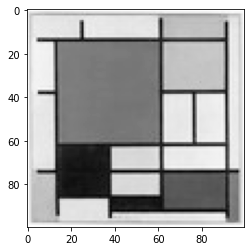

In [3]:
from matplotlib.image import imread

data = imread('../data/mondrian_small.jpg').sum(axis=2)
data = data/data.max()
im_true = torch.Tensor(data)
im_true = im_true.to(device=device)

plt.imshow(im_true.cpu().detach().numpy(), 'Greys_r')

In [4]:
im_true.shape

torch.Size([100, 100])

In [5]:
shape = im_true.shape

In [6]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, rows, cols, n_factors=10):
        super().__init__()
        self.row_embedding = torch.nn.parameter.Parameter(torch.rand(rows, n_factors), requires_grad=True)
        self.col_embedding = torch.nn.parameter.Parameter(torch.rand(n_factors, cols), requires_grad=True)

    def forward(self):
        return torch.matmul( self.row_embedding, self.col_embedding )

In [7]:
im_true.shape

torch.Size([100, 100])

In [8]:
mf = MatrixFactorization(100, 100, 10).to(device=device)

In [9]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(mf.parameters(), lr=0.001)

In [10]:
for epoch in range(100000):
    
    optimizer.zero_grad()

    output = mf.forward()
    loss = criterion(output,im_true)
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(loss)

tensor(3.9910, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9831, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.4252, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2435, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1664, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1278, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1060, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0925, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0835, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0771, device='cuda:0', grad_fn=<MseLossBackward>)


In [11]:
torch.norm((mf.row_embedding @ mf.col_embedding) - im_true)

tensor(26.8811, device='cuda:0', grad_fn=<CopyBackwards>)

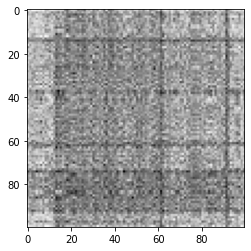

In [12]:
plt.imshow( (mf.row_embedding @ mf.col_embedding).cpu().detach().numpy() , cmap='Greys_r')

In [24]:
mf2 = MatrixFactorization(100, 100, 10).to(device=device)

In [25]:
def laplacian_loss(X):
    added_dims = torch.unsqueeze(torch.unsqueeze(X,dim=0),dim=0)
    laplacian_kernel = torch.Tensor([[ [[0.,-1.,0.],[-1.,2.,-1.],[0.,-1.,0.]] ]]).to(device=device)

    return F.conv2d(added_dims, laplacian_kernel).pow(2).sum()
    
criterion = nn.MSELoss()
optimizer = optim.SGD(mf2.parameters(), lr=0.001)

In [26]:
def total_variation_loss(X):
    """
    This loss function returns the sum of the L1 total variations of each generated feature.
    """
    
    # get masked features
    # reshape back to 3D, filling gaps with zeros
    # compute total variation across each feature
    # sum TV values for each feature
    
    #multimask = torch.stack( [mask]*100, dim=4 ) # stack the mask into the channel dimension to make filtering easier
    
    #x[~multimask] = 0.0 # set all values that are outside the mask to zero
    
    x_diffs = X[1:, :] - X[:-1, :]
    
    y_diffs = X[:, 1:] - X[:, :-1]
    
    TV = x_diffs.abs().sum() + y_diffs.abs().sum()
    
    return TV

In [34]:
for epoch in range(100000):
    
    optimizer.zero_grad()

    output = mf2.forward()
    loss = criterion(output, im_true) + 0.0001*laplacian_loss(output) + 0.0001*total_variation_loss(output)
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(loss)

tensor(0.3798, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3597, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3474, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3393, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3335, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3259, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3233, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3211, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3193, device='cuda:0', grad_fn=<AddBackward0>)


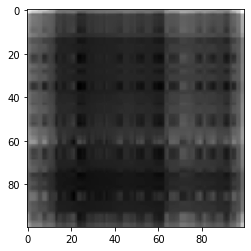

In [35]:
plt.imshow(output.cpu().detach().numpy(), 'Greys_r')

In [36]:
torch.linalg.norm((mf.row_embedding @ mf.col_embedding) - im_true)

tensor(26.8811, device='cuda:0', grad_fn=<CopyBackwards>)